In [22]:
import numpy as np
from ipywidgets import interactive, widgets,fixed
from IPython.display import Audio, display
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib import rc,rcParams
rc('text', usetex=True)
rcParams['figure.figsize'] = (8, 6.5)
rcParams['ytick.labelsize'],rcParams['xtick.labelsize'] = 17.,17.
rcParams['axes.labelsize']=19.
rcParams['legend.fontsize']=17.
rcParams['axes.titlesize']=20.
rcParams['text.latex.preamble'] = ['\\usepackage{siunitx}']
import seaborn
seaborn.despine()
seaborn.set_style('white', {'axes.linewidth': 0.5, 'axes.edgecolor':'black'})
seaborn.despine(left=True)
%load_ext autoreload
from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test
from astropy.table import Table
from scipy import polyfit,linalg
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
data = fetch_hogg2010test()
data = data[5:]  # no outliers
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

In [27]:
t = Table([x, y, sigma_x,sigma_y,rho_xy], names=('X', 'Y', '$\sigma _x$','$\sigma _y$','$\\rho _{xy}$'))#, meta={'name': 'first table'})
t

X,Y,$\sigma _x$,$\sigma _y$,$\rho _{xy}$
float64,float64,float64,float64,float64
58.0,173.0,9.0,15.0,0.67
210.0,479.0,4.0,27.0,-0.02
202.0,504.0,4.0,14.0,-0.05
198.0,510.0,11.0,30.0,-0.84
158.0,416.0,7.0,16.0,-0.69
165.0,393.0,5.0,14.0,0.3
201.0,442.0,5.0,25.0,-0.46
157.0,317.0,5.0,52.0,-0.03
131.0,311.0,6.0,16.0,0.5


<Container object of 3 artists>

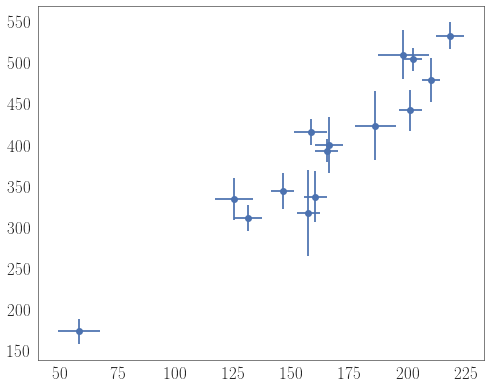

In [14]:
plt.errorbar(x,y,yerr=sigma_y,xerr=sigma_x,fmt='o')

In [30]:
def f(x,b,m): return b+m*x
Mcf,dMcf2=curve_fit(f,x,y,[2.,30.],sigma=sigma_y)
dMcf=np.sqrt(np.diag(dMcf2))
print Mcf, dMcf
print 'Y=({:.1f} +- {:.1f}) + ({:.1f} +- {:.2f}) X'.format(Mcf[0],dMcf[0],Mcf[1],dMcf[1])

[ 34.84594131   2.23253622] [ 22.02571655   0.13189614]
Y=(34.8 +- 22.0) + (2.2 +- 0.13) X


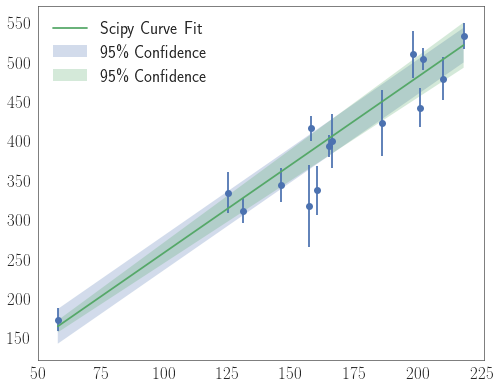

In [31]:
xx=np.linspace(x.min(),x.max())
plt.errorbar(x,y,yerr=sigma_y,fmt='o')
plt.plot(xx,f(xx,Mcf[0],Mcf[1]),label='Scipy Curve Fit')
plt.fill_between(xx,f(xx,Mcf[0]-dMcf[0],Mcf[1]),f(xx,Mcf[0]+dMcf[0],Mcf[1]),alpha=0.25,label='95\% Confidence')
plt.fill_between(xx,f(xx,Mcf[0],Mcf[1]-dMcf[1]),f(xx,Mcf[0],Mcf[1]+dMcf[1]),alpha=0.25,label='95\% Confidence')

plt.legend(loc='best')

In [47]:
N=200
bb=np.linspace(-40,110,N)
mm=np.linspace(1.75,2.7,N)
LogL=np.zeros((len(bb),len(mm)))
for i,b in enumerate(bb):
    for j,m in enumerate(mm):
        LogL[i,j]=np.sum((y-f(x,b,m))**2/sigma_y**2)
print LogL.min(),LogL.mean()

18.5852705329 166.429861153


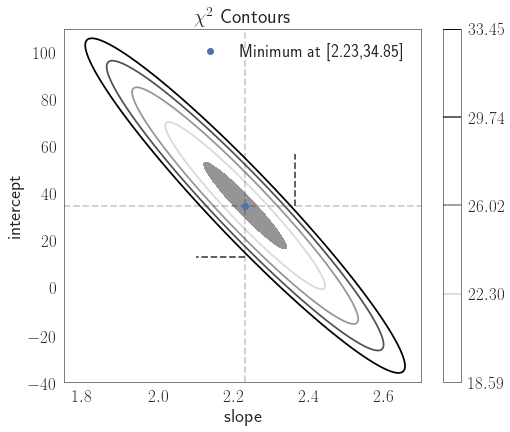

In [60]:
ax=plt.subplot()
c=ax.contour(LogL,np.linspace(LogL.min(),1.8*LogL.min(),5),extent=[mm.min(),mm.max(),bb.min(),bb.max()])
c2=ax.contourf(LogL,[LogL.min(),LogL.min()+1],extent=[mm.min(),mm.max(),bb.min(),bb.max()],label='$\chi ^2+1$')
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.vlines(Mcf[1],bb.min(),bb.max(),linestyles='--',alpha=0.2)
ax.hlines(Mcf[0],mm.min(),mm.max(),linestyles='--',alpha=0.2)
ax.vlines(Mcf[1]+dMcf[1],Mcf[0],Mcf[0]+dMcf[0],linestyles='--',alpha=0.7)#,label=r'Intercept $\sigma$')
ax.hlines(Mcf[0]-dMcf[0],Mcf[1],Mcf[1]-dMcf[1],linestyles='--',alpha=0.7)#,label=r'Slope $\sigma$')
ax.plot([Mcf[1]],[Mcf[0]],'o',label='Minimum at [{:.2f},{:.2f}]'.format(Mcf[1],Mcf[0]))
ax.set_title('$\chi ^2$ Contours')
plt.colorbar(c,ax=ax)
ax.legend()